In [1]:
import re #pacchetto per espressioni regolari
import os #pacchetto per muoversi nelle cartelle

In [2]:
conllu_dir = 'profiling_output/11152/'

In [3]:
class Document:

    def __init__(self, document_path):
        self.document_path = document_path
        self._parse_doc_info(document_path)
        self.sentences = []
        self.features = None

    def _parse_doc_info(self, document_path):
        document_path = document_path.split('/')[-1]
        document_info = document_path.split('.')[0]
        document_info = document_info.split('#')
        self.split = document_info[0]
        self.genre = document_info[2]
        self.gender = document_info[3]

    def add_sentence(self, sentences):
        self.sentences.append(sentences)

    # Per dopo

    def get_num_tokens(self):
        num_words = 0
        for sentence in self.sentences:
            num_words = num_words + sentence.get_num_tokens()
        return num_words

    def get_num_chars(self):
        num_chars = 0
        for sentence in self.sentences:
            sentence_char_len = sentence.get_num_chars()
            num_chars = num_chars + sentence_char_len
        return num_chars

class Sentence:

    def __init__(self):
        self.tokens = []

    def add_token(self, token):
        self.tokens.append(token)

    # Per dopo

    def get_words(self):
        return [token.word for token in self.tokens]

    def get_lemmas(self):
        return [token.lemma for token in self.tokens]

    def get_pos(self):
        return [token.pos for token in self.tokens]

    def get_num_tokens(self):
        return len(self.tokens)

    def get_num_chars(self):
        num_chars = 0
        for token in self.tokens:
            num_chars = num_chars + token.get_num_chars()
        num_chars = num_chars + self.get_num_tokens() - 1 # contiamo anche gli spazi
        return num_chars

    def __str__(self):
        return ' '.join([token.word for token in self.tokens])

class Token:

    def __init__(self, word, lemma, pos):
        self.word = word
        self.lemma = lemma
        self.pos = pos


    # Per dopo

    def get_num_chars(self):
        return len(self.word)

In [4]:
def load_document_sentences(document):
    sentence = Sentence()
    for line in open(document.document_path, 'r'):
        if line[0].isdigit():  # se la riga inizia con un numero
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino
                token = Token(splitted_line[1], splitted_line[2], splitted_line[3])
                sentence.add_token(token)
        if line == '\n':  # se la riga è vuota significa che la frase è finita
            document.add_sentence(sentence)
            sentence = Sentence()

In [5]:
all_documents = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    document = Document(file_path)
    load_document_sentences(document)
    all_documents.append(document)

In [6]:
sample_document = all_documents[0]
for sentence in sample_document.sentences[:2]:
    tokens = [token.word for token in sentence.tokens]
    print(' - '.join(tokens))
    print('\n_________________\n')

" - Gay - Pride - ?

_________________

Solo - folklore - " - .

_________________



In [7]:
sample_sentence = sample_document.sentences[0]
print(sample_sentence)

" Gay Pride ?


In [8]:
def extract_word_ngrams_from_sentence(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    if el == 'word':
        all_words = sentence.get_words()
    elif el == 'lemma':
        all_words = sentence.get_lemmas()
    elif el == 'pos':
        all_words = sentence.get_pos()
    else:
        raise Exception(f'Invalid element {el}')
    

    # scorriamo la lista delle parole ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1): # -n+1 serve per non uscire dal vettore
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        # print(f'{i}: {ngram_words} -> {ngram}')
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1

    return word_ngrams

In [9]:
extract_word_ngrams_from_sentence(dict(), sample_sentence, 'word', 3)


{'WORD_3_"_Gay_Pride': 1, 'WORD_3_Gay_Pride_?': 1}

In [10]:
def extract_char_ngrams_from_sentence(char_ngrams, sentence, n):
    # creiamo una lista con tutte le parole
    all_words = sentence.get_words()

    # creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    # print(all_words)
    # all_words = all_words.lower()

    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars
        # print(f'{i}: {ngram_chars} -> {ngram}')

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1

    return char_ngrams

In [11]:
extract_char_ngrams_from_sentence(dict(), sample_sentence, 2);


In [12]:
print(sample_document.features)


None


In [13]:
def extract_documents_ngrams(all_documents):
    for document in all_documents:
        document_ngrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(document_ngrams, sentence, 'word', 1)
            extract_word_ngrams_from_sentence(document_ngrams, sentence, 'word', 2)
            extract_char_ngrams_from_sentence(document_ngrams, sentence, 1)
            extract_char_ngrams_from_sentence(document_ngrams, sentence, 2)

        document.features = document_ngrams

In [14]:
extract_documents_ngrams(all_documents)


In [15]:
sample_document.features

{'WORD_1_"': 29,
 'WORD_1_Gay': 4,
 'WORD_1_Pride': 12,
 'WORD_1_?': 2,
 'WORD_2_"_Gay': 2,
 'WORD_2_Gay_Pride': 4,
 'WORD_2_Pride_?': 2,
 'CHAR_1_"': 29,
 'CHAR_1_ ': 899,
 'CHAR_1_G': 8,
 'CHAR_1_a': 421,
 'CHAR_1_y': 5,
 'CHAR_1_P': 25,
 'CHAR_1_r': 254,
 'CHAR_1_i': 519,
 'CHAR_1_d': 156,
 'CHAR_1_e': 411,
 'CHAR_1_?': 2,
 'CHAR_2_" ': 28,
 'CHAR_2_ G': 7,
 'CHAR_2_Ga': 5,
 'CHAR_2_ay': 4,
 'CHAR_2_y ': 5,
 'CHAR_2_ P': 23,
 'CHAR_2_Pr': 13,
 'CHAR_2_ri': 42,
 'CHAR_2_id': 16,
 'CHAR_2_de': 35,
 'CHAR_2_e ': 185,
 'CHAR_2_ ?': 2,
 'WORD_1_Solo': 2,
 'WORD_1_folklore': 4,
 'WORD_1_.': 30,
 'WORD_2_Solo_folklore': 2,
 'WORD_2_folklore_"': 2,
 'WORD_2_"_.': 14,
 'CHAR_1_S': 7,
 'CHAR_1_o': 427,
 'CHAR_1_l': 226,
 'CHAR_1_f': 37,
 'CHAR_1_k': 7,
 'CHAR_1_.': 31,
 'CHAR_2_So': 3,
 'CHAR_2_ol': 23,
 'CHAR_2_lo': 13,
 'CHAR_2_o ': 160,
 'CHAR_2_ f': 16,
 'CHAR_2_fo': 10,
 'CHAR_2_lk': 6,
 'CHAR_2_kl': 6,
 'CHAR_2_or': 37,
 'CHAR_2_re': 63,
 'CHAR_2_ "': 20,
 'CHAR_2_ .': 30,
 'WORD_1_A': 

In [16]:
def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram] / float(doc_len)
        
def extract_documents_ngrams_normalized(all_documents):
    for document in all_documents:
        word_unigrams = dict()
        word_bigrams = dict()
        char_unigrams = dict()
        char_bigrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams_from_sentence(word_bigrams, sentence, 'word', 2)
            extract_char_ngrams_from_sentence(char_unigrams, sentence, 1)
            extract_char_ngrams_from_sentence(char_bigrams, sentence, 2)

        num_words = document.get_num_tokens()
        num_chars = document.get_num_chars()
        normalize_ngrams(word_unigrams, num_words)
        normalize_ngrams(word_bigrams, num_words)
        normalize_ngrams(char_unigrams, num_chars)
        normalize_ngrams(char_bigrams, num_chars)

        document_ngrams = word_unigrams | word_bigrams | char_unigrams | char_bigrams

        # user_features = dict()
        # for ngrams_dict in [word_unigrams, word_bigrams, char_unigrams, char_bigrams]:
        #     for ngram in ngrams_dict:
        #         user_features[ngram] = ngrams_dict[ngram]

        document.features = document_ngrams

In [17]:
extract_documents_ngrams_normalized(all_documents)


In [18]:
sample_document.features

{'WORD_1_"': 0.030982905982905984,
 'WORD_1_Gay': 0.004273504273504274,
 'WORD_1_Pride': 0.01282051282051282,
 'WORD_1_?': 0.002136752136752137,
 'WORD_1_Solo': 0.002136752136752137,
 'WORD_1_folklore': 0.004273504273504274,
 'WORD_1_.': 0.03205128205128205,
 'WORD_1_A': 0.004273504273504274,
 'WORD_1_Novara': 0.01282051282051282,
 'WORD_1_il': 0.06623931623931624,
 'WORD_1_sindaco': 0.014957264957264958,
 'WORD_1_leghista': 0.003205128205128205,
 'WORD_1_nega': 0.003205128205128205,
 'WORD_1_patrocinio': 0.009615384615384616,
 'WORD_1_ed': 0.002136752136752137,
 'WORD_1_è': 0.008547008547008548,
 'WORD_1_polemica': 0.002136752136752137,
 'WORD_1_Canelli': 0.007478632478632479,
 'WORD_1_,': 0.04700854700854701,
 'WORD_1_già': 0.0010683760683760685,
 'WORD_1_a': 0.029914529914529916,
 'WORD_1_centro': 0.0010683760683760685,
 'WORD_1_di': 0.05448717948717949,
 'WORD_1_le': 0.009615384615384616,
 'WORD_1_critiche': 0.0010683760683760685,
 'WORD_1_per': 0.00641025641025641,
 'WORD_1_no': 0

In [19]:
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.gender)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.gender)
    
    return train_features_dict, train_labels, test_features_dict, test_labels

In [20]:
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)

In [21]:
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels)


(200, 200, 200, 200)

In [22]:
def get_num_features(features_dict):
    all_features = set()
    for document_feats in features_dict:
        all_features.update(list(document_feats.keys()))
    return len(all_features)

In [23]:
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')

Numero features: 96238


In [24]:
def filter_features(train_features_dict, min_occurrences):
    # contiamo ogni feature in quanti user diversi compare
    features_counter = dict()
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" utenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict

In [25]:
train_features_dict = filter_features(train_features_dict, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')

Numero features dopo il filtro: 5754


In [26]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)

In [27]:
vectorizer.get_feature_names_out(X_train).tolist()

['CHAR_1_ ',
 'CHAR_1_!',
 'CHAR_1_"',
 'CHAR_1_%',
 'CHAR_1_&',
 "CHAR_1_'",
 'CHAR_1_(',
 'CHAR_1_)',
 'CHAR_1_,',
 'CHAR_1_-',
 'CHAR_1_.',
 'CHAR_1_/',
 'CHAR_1_0',
 'CHAR_1_1',
 'CHAR_1_2',
 'CHAR_1_3',
 'CHAR_1_4',
 'CHAR_1_5',
 'CHAR_1_6',
 'CHAR_1_7',
 'CHAR_1_8',
 'CHAR_1_9',
 'CHAR_1_:',
 'CHAR_1_;',
 'CHAR_1_?',
 'CHAR_1_A',
 'CHAR_1_B',
 'CHAR_1_C',
 'CHAR_1_D',
 'CHAR_1_E',
 'CHAR_1_F',
 'CHAR_1_G',
 'CHAR_1_H',
 'CHAR_1_I',
 'CHAR_1_J',
 'CHAR_1_K',
 'CHAR_1_L',
 'CHAR_1_M',
 'CHAR_1_N',
 'CHAR_1_O',
 'CHAR_1_P',
 'CHAR_1_Q',
 'CHAR_1_R',
 'CHAR_1_S',
 'CHAR_1_T',
 'CHAR_1_U',
 'CHAR_1_V',
 'CHAR_1_W',
 'CHAR_1_Y',
 'CHAR_1_Z',
 'CHAR_1_a',
 'CHAR_1_b',
 'CHAR_1_c',
 'CHAR_1_d',
 'CHAR_1_e',
 'CHAR_1_f',
 'CHAR_1_g',
 'CHAR_1_h',
 'CHAR_1_i',
 'CHAR_1_j',
 'CHAR_1_k',
 'CHAR_1_l',
 'CHAR_1_m',
 'CHAR_1_n',
 'CHAR_1_o',
 'CHAR_1_p',
 'CHAR_1_q',
 'CHAR_1_r',
 'CHAR_1_s',
 'CHAR_1_t',
 'CHAR_1_u',
 'CHAR_1_v',
 'CHAR_1_w',
 'CHAR_1_x',
 'CHAR_1_y',
 'CHAR_1_z',
 'CHAR_1_~',

In [28]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 0.01, 0.001, 0.0001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Best parameters found: {'C': 0.1, 'dual': True}
Best score found: 0.585


In [30]:
X_test = vectorizer.transform(test_features_dict)
X_test = scaler.transform(X_test)

In [31]:
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

In [32]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True

              precision    recall  f1-score   support

           F       0.50      0.57      0.53       100
           M       0.49      0.42      0.45       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



In [33]:
print(confusion_matrix(test_labels, test_predictions))

[[57 43]
 [58 42]]


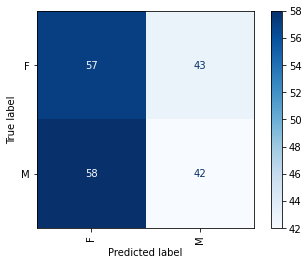

In [34]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')

# Kfold

In [35]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold
y_train = np.asarray(train_labels)

In [36]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(X_train))

for i in range(len(folds)):
    print(len(folds[i][0]), len(folds[i][1]))

160 40
160 40
160 40
160 40
160 40


In [37]:
all_y_true = []
all_y_pred = []

# for i, (train_ids, test_ids) in enumerate(splitter.split(X_train)):
for i in range(len(folds)):
    train_ids = folds[i][0]
    test_ids = folds[i][1]


    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test = X_train[test_ids]
    fold_y_test = y_train[test_ids]

    kfold_svc = LinearSVC(dual=True, C=0.1)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()
    print(f"Accuracy fold {i+1}: {fold_accuracy}")

Accuracy fold 1: 0.7
Accuracy fold 2: 0.7
Accuracy fold 3: 0.725
Accuracy fold 4: 0.8
Accuracy fold 5: 0.75


In [38]:
print(classification_report(all_y_true, all_y_pred, zero_division=0))

              precision    recall  f1-score   support

           F       0.74      0.72      0.73       100
           M       0.73      0.75      0.74       100

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



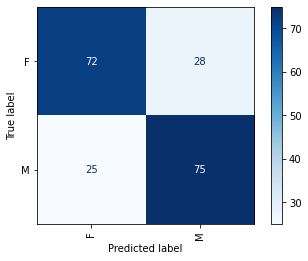

In [39]:
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues')

In [40]:
best_model.classes_

array(['F', 'M'], dtype='<U1')

In [41]:
coefs = best_model.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape

(1, 5754)

In [42]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names

['CHAR_1_ ',
 'CHAR_1_!',
 'CHAR_1_"',
 'CHAR_1_%',
 'CHAR_1_&',
 "CHAR_1_'",
 'CHAR_1_(',
 'CHAR_1_)',
 'CHAR_1_,',
 'CHAR_1_-',
 'CHAR_1_.',
 'CHAR_1_/',
 'CHAR_1_0',
 'CHAR_1_1',
 'CHAR_1_2',
 'CHAR_1_3',
 'CHAR_1_4',
 'CHAR_1_5',
 'CHAR_1_6',
 'CHAR_1_7',
 'CHAR_1_8',
 'CHAR_1_9',
 'CHAR_1_:',
 'CHAR_1_;',
 'CHAR_1_?',
 'CHAR_1_A',
 'CHAR_1_B',
 'CHAR_1_C',
 'CHAR_1_D',
 'CHAR_1_E',
 'CHAR_1_F',
 'CHAR_1_G',
 'CHAR_1_H',
 'CHAR_1_I',
 'CHAR_1_J',
 'CHAR_1_K',
 'CHAR_1_L',
 'CHAR_1_M',
 'CHAR_1_N',
 'CHAR_1_O',
 'CHAR_1_P',
 'CHAR_1_Q',
 'CHAR_1_R',
 'CHAR_1_S',
 'CHAR_1_T',
 'CHAR_1_U',
 'CHAR_1_V',
 'CHAR_1_W',
 'CHAR_1_Y',
 'CHAR_1_Z',
 'CHAR_1_a',
 'CHAR_1_b',
 'CHAR_1_c',
 'CHAR_1_d',
 'CHAR_1_e',
 'CHAR_1_f',
 'CHAR_1_g',
 'CHAR_1_h',
 'CHAR_1_i',
 'CHAR_1_j',
 'CHAR_1_k',
 'CHAR_1_l',
 'CHAR_1_m',
 'CHAR_1_n',
 'CHAR_1_o',
 'CHAR_1_p',
 'CHAR_1_q',
 'CHAR_1_r',
 'CHAR_1_s',
 'CHAR_1_t',
 'CHAR_1_u',
 'CHAR_1_v',
 'CHAR_1_w',
 'CHAR_1_x',
 'CHAR_1_y',
 'CHAR_1_z',
 'CHAR_1_~',

Feature importance class F


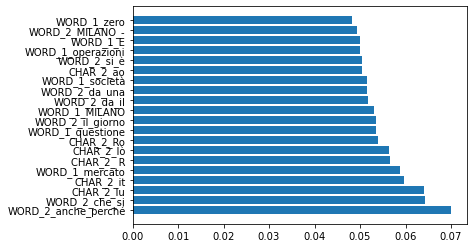

In [43]:
import matplotlib.pyplot as plt

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

num_to_plot = 20
print(f'Feature importance class {best_model.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()


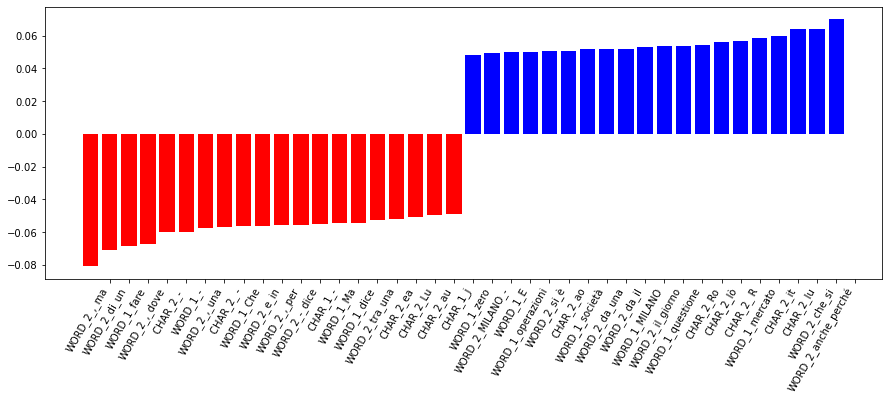

In [44]:
 coef = coefs.ravel()
 top_positive_coefficients = np.argsort(coef)[-20:]
 top_negative_coefficients = np.argsort(coef)[:20]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * 20), coef[top_coefficients], color=colors)
 feature_names = np.array(features_names)
 plt.xticks(np.arange(1, 1 + 2 * 20), feature_names[top_coefficients], rotation=60, ha="right")
 plt.show()

Feature importance class F


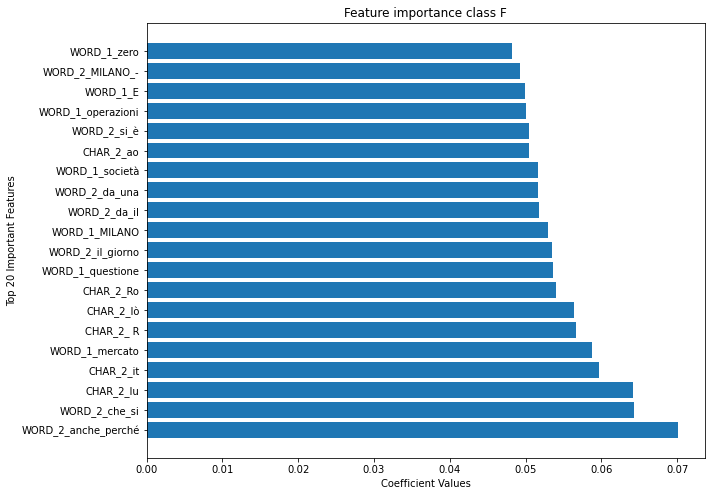

IndexError: index 1 is out of bounds for axis 0 with size 1

In [45]:
import matplotlib.pyplot as plt

# Assuming `coefs` is your coefficients obtained from the SVM model
# Assuming `features_names` is a list containing the names of your features
# Assuming `svc.classes_` contains the class labels 'F' and 'M'
for idx, class_label in enumerate(best_model.classes_):
    class_coefs = coefs[idx]

    feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
    sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

    num_to_plot = 20
    print(f'Feature importance class {class_label}')
    plt.figure(figsize=(10, 8))
    plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
    plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
    plt.title(f'Feature importance class {class_label}')
    plt.xlabel('Coefficient Values')
    plt.ylabel('Top 20 Important Features')
    plt.show()
